# Histopathologic Cancer Detection

### Description of the problem and data

In this exercise I'm going to build a model for Histopathologic Cancer Detection, using the data from Kaggle competition.

https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

The available data is organized in two folders; train and test, with images patches of patology scans. In addition there is a file called "train_labels.csv", which contains the labels for the images of the training set, with values of 1 in cases when cancer is possitive and 0 when is negative.


As is require in this course, I created a GitHub repository  for this project:

https://github.com/edmon2017/Histopathologic-Cancer-Detection


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

In [2]:
# Import the label file
train_path = 'train'
labels = pd.read_csv("train_labels.csv")

print(labels.shape)
labels.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


After analyze the train_label file, we can notice there are 220025 images available for training, which are inisde the training folder.
This file has two colums; 'id' with the idientifier of the image and 'label' with value of 1 in cases when cancer is possitive and 0 when is negative.

### Exploratory Data Analysis (EDA)

The first step is to combine the labels with the names of the files inside the train folder, to use the data later.

After, I'm going to verify this points:
*   Duplicated Id's
*   Labels with missing data
*   Imbalance of the labels








In [4]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('\\')[1].split(".")[0])
df = df.merge(labels, on = "id")
df.head()

,path,id,label
0,train\00001b2b5609af42ab0ab276dd4cd41c3e7745b5...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,train\000020de2aa6193f4c160e398a8edea95b1da598...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,train\00004aab08381d25d315384d646f5ce413ea24b1...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,train\0000d563d5cfafc4e68acb7c9829258a298d9b6a...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,train\0000da768d06b879e5754c43e2298ce48726f722...,0000da768d06b879e5754c43e2298ce48726f722,1


In [5]:
df.shape

(220025, 3)

In [6]:
#Verify if there is duplicate data
print(f"Duplicated data: '{df['id'].duplicated().any()}'")

print(f"Empty labels: '{df['label'].isnull().any()}'")


Duplicated data: 'False'
Empty labels: 'False'


Now, I'm going to analyze if there is an imbalance in the data

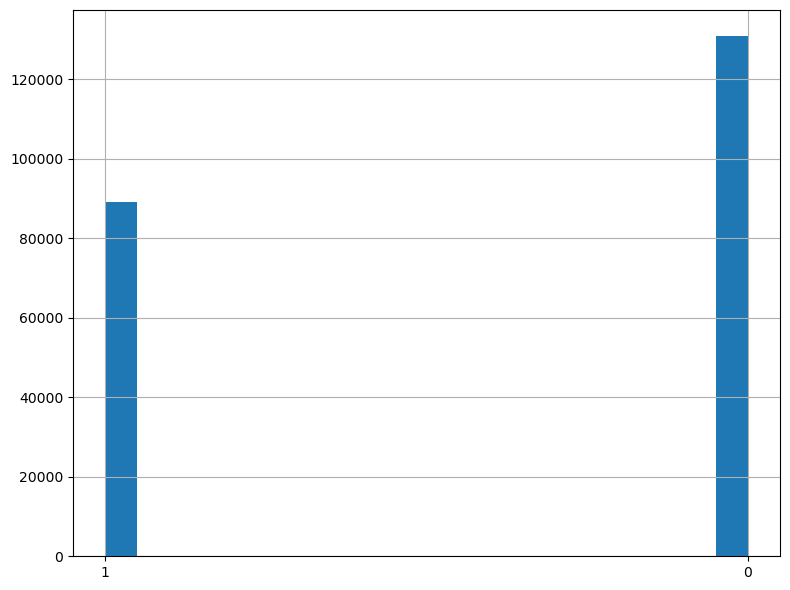

0    130908
1     89117
Name: label, dtype: int64

In [7]:
df['label'] = df['label'].astype(str)

# Plot histogram
df['label'].hist(bins=20, figsize=(8, 6))
plt.tight_layout()
plt.show()

df['label'].value_counts()

After analyze the data we can conclude there are not duplicated data or empty labels, in addtion there is an imbalance in the labels, but I'm not going to modify current data.

### Processing
The processing has the next steps:
* The first step it to split the training data in training and validation, for this I use 20% of the data.
* Next is a real-time data augmentation pipeline that will randomly transform your images, this step helps the model to generalize better
* Define the target height & width for every image (IMG_SIZE).
* Number of images passed through the network in each training or validation step (BATCH_SIZE).
* Finally I create two Keras data generators that read image file paths and labels from DataFrames.

In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label, random_state=42)

In [9]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)
val_aug = ImageDataGenerator(rescale=1./255)

IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [34]:
train_gen = train_aug.flow_from_dataframe(
    train_df, x_col="path", y_col="label",
    target_size=IMG_SIZE, class_mode="binary", batch_size=BATCH_SIZE, shuffle=True
)
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="path", y_col="label",
    target_size=IMG_SIZE, class_mode="binary", batch_size=BATCH_SIZE, shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Model Architecture

For this project I'm going to use a CNN model, to accelerate the training process I use transfer learning using as base model the EfficientNet model. The feature-extraction layers are frozen, and then I add a trainable head for binary classification.

For tune the hyperparameters, I tested different learning rates, and obtained the best results with the selected one.

In [37]:
from tensorflow.keras.applications import EfficientNetB0
#Base model EfficientNetB0 (frozen)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)
base_model.trainable = False

inp = layers.Input(shape=(*IMG_SIZE, 3))
x = base_model(inp, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inp, outputs=out)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 4,377,764
Trainable params: 328,193
Non-trainable params: 4,049,571
______________________________________

In [8]:
ckpt = callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_auc", mode="max", save_best_only=True
)
early = callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=5, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7
)

In [9]:
EPOCHS = 20
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[ckpt, early, reduce_lr]
)

Epoch 1/20
5501/5501 [==============================] - 6714s 1s/step - loss: 0.6713 - accuracy: 0.5907 - auc: 0.5462 - val_loss: 0.6633 - val_accuracy: 0.5950 - val_auc: 0.5593


C:\Users\adria\anaconda3\envs\GPU_37\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
5501/5501 [==============================] - 3361s 611ms/step - loss: 0.6637 - accuracy: 0.5804 - auc: 0.5717 - val_loss: 0.6519 - val_accuracy: 0.5115 - val_auc: 0.5737
Epoch 3/20
5501/5501 [==============================] - 3317s 603ms/step - loss: 0.6519 - accuracy: 0.5824 - auc: 0.5926 - val_loss: 0.6282 - val_accuracy: 0.5950 - val_auc: 0.6499
Epoch 4/20
5501/5501 [==============================] - 3338s 607ms/step - loss: 0.6353 - accuracy: 0.6088 - auc: 0.6397 - val_loss: 0.6138 - val_accuracy: 0.7102 - val_auc: 0.7597
Epoch 5/20
5501/5501 [==============================] - 3297s 599ms/step - loss: 0.6196 - accuracy: 0.6459 - auc: 0.6937 - val_loss: 0.5952 - val_accuracy: 0.6892 - val_auc: 0.7708
Epoch 6/20
5501/5501 [==============================] - 3290s 598ms/step - loss: 0.6054 - accuracy: 0.6685 - auc: 0.7235 - val_loss: 0.5786 - val_accuracy: 0.7360 - val_auc: 0.7790
Epoch 7/20
5501/5501 [==============================] - 3326s 605ms/step - loss: 0.5927 - accur

### Results and Analysis Hyperparameter tunning

These initial plots are from a different model using different EPOCHS = 10 and Learning Rate = 0.001, the results are worst compared with the model used in the project

In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model02 = models.Model(inputs, outputs)
model02.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [ ]:
EPOCHS = 10
history02 = model02.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[ckpt, early, reduce_lr]
)

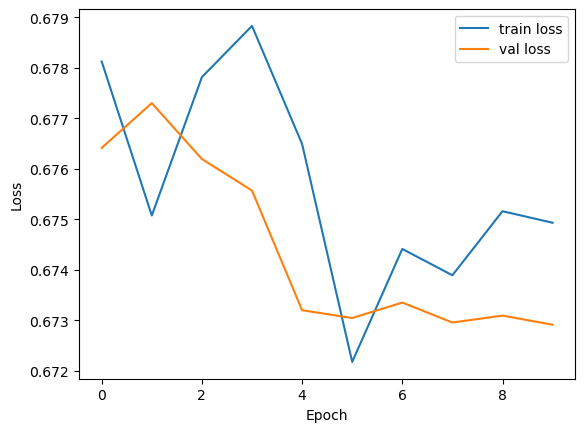

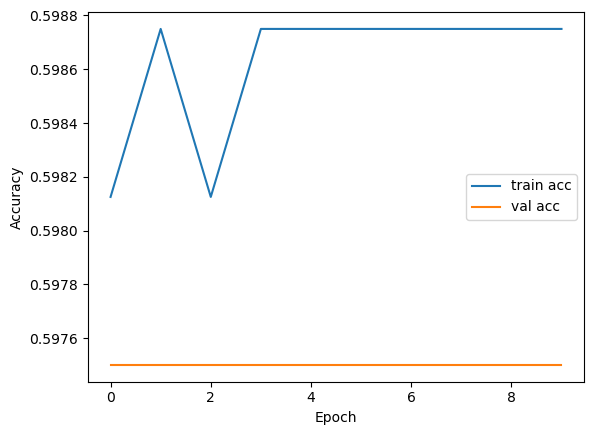

In [18]:
plt.plot(history02.history['loss'],    label='train loss')
plt.plot(history02.history['val_loss'],label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exactitud
plt.plot(history02.history['accuracy'],    label='train acc')
plt.plot(history02.history['val_accuracy'],label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After analyze different scenarios, the parameters I used are EPOCHS =20 and Adam Optimizer with learning_rate=1e-4. The results are sumarize in the next plots for Loss and Accuracy

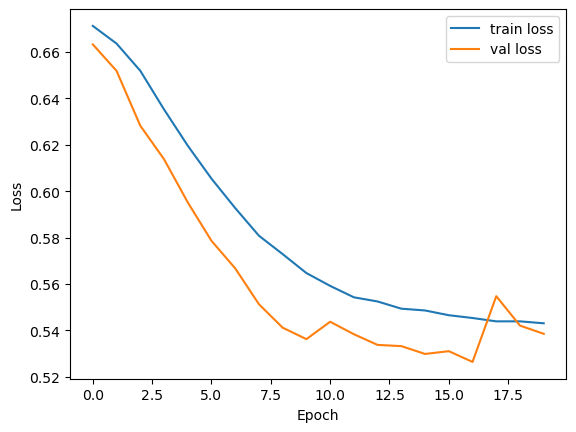

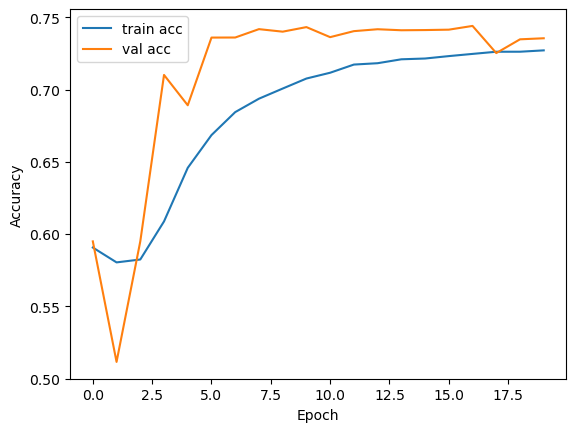

In [26]:
import matplotlib.pyplot as plt
plt.plot(history['loss'],    label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exactitud
plt.plot(history['accuracy'],    label='train acc')
plt.plot(history['val_accuracy'],label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Next I'm going to calculate and plot the ROC curve

In [86]:
y_prob = model.predict(val_gen).ravel()
y_prob1 = np.where(y_prob >= 0.5, 1, 0)

In [75]:
y_true = val_gen.classes
y_prob1 = np.where(y_prob >= 0.5, 1, 0)
y_true1 = np.array(y_true.values).astype(int)

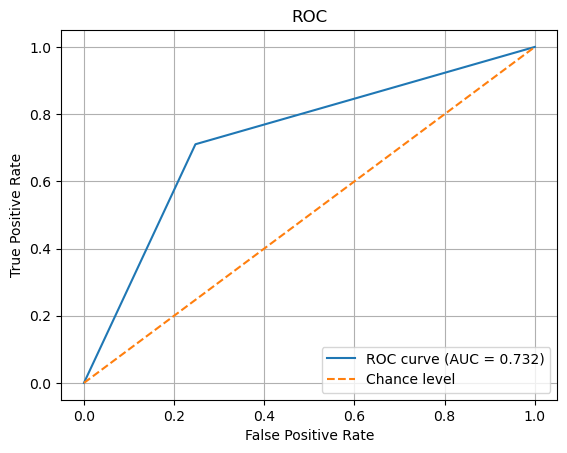

In [74]:
#Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true1, y_prob1)
roc_auc = auc(fpr, tpr)

#Plotting
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', label='Chance level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Test Prediction
For the test dataset I follow a similar process, generating a Dataframe with the 'id' and 'path' for the files, processing the data and predicting the results using the CNN model

In [76]:
test_path='test'
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 
df_test['id'] = df_test.path.map(lambda x: x.split('\\')[1].split(".")[0])  
df_test.head(3)

,path,id
0,test\00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2


In [79]:
test_aug = ImageDataGenerator(rescale=1./255)
test_gen = test_aug.flow_from_dataframe(
    df_test, x_col="path",
    target_size=IMG_SIZE, class_mode=None, batch_size=BATCH_SIZE, shuffle=False
)

Found 57458 validated image filenames.


In [81]:
test_prob = model.predict(test_gen).ravel()

In [ ]:
y_prob1 = np.where(y_prob >= 0.5, 1, 0)
lst_bin = [1 if x > 0.5 else 0 for x in lst]

In [ ]:
results = pd.concat([submission, data_frame[['id', 'label']]])

### Conclusion

The CNN model using EfficientNet as base model, has a good performance, however the result still can be improved trying differente hyperparameters or a different base model. The main problem is the time required to train the model with different parameters, I try a couple of scenarios, but probably there are better options that I didn't test because of this compunting time requirements.

One of the strategies I try for different hyperparameter was using an small dataset, however the performance was poor because of the overfiting generated because of this large number of parameters of the model against the small number of samples.

At the end I train a few model with different parameters, but the limitation is that I only could consider a few scenarios